In [ ]:
import torch
import torch.nn as nn
from utils import *
import random
import time
import pdb
import json
import math

In [ ]:
n_letters = 58
n_categories = 18
n_hidden = 128
n_epochs = 100
print_every = 5000
plot_every = 1000
learning_rate = 0.00001  # If you set this too high, it might explode. If too low, it might not learn


class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        Args:
            input_shape (int): size of the 1-hot embeddings for each character (this will be 58)
            hidden_layer_width (int): number of nodes in the single hidden layer within the model
            n_classes (int): number of output classes
        """
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size

        self.W_U_h = nn.Linear(input_size + hidden_size, hidden_size, bias=True)
        self.W_U_y = nn.Linear(input_size + hidden_size, output_size, bias=True)

        self.softmax_fnc = nn.Softmax(dim=1)

    def forward(self, input, hidden):
        """Forward function accepts tensor of input data, returns tensor of output data.
        Modules defined in constructor are used, along with arbitrary operators on tensors
        """

        input_cat_hidden = torch.hstack((input, hidden))

        # input_cat_hidden = input_cat_hidden.squeeze()

        h_t = self.W_U_h(input_cat_hidden)

        y_t = self.softmax_fnc(self.W_U_y(input_cat_hidden))

        # y_t = y_t.squeeze()

        # your function will return the output y(t) and hidden h(t) from equation 1 in the docs
        #         print('h_t')
        #         print(h_t.shape)
        #         print('y_t')
        #         print(y_t.shape)
        #         print('self.W_U_h.weight')
        #         print(self.W_U_h.weight.shape)
        #         print('input')
        #         print(input.shape)
        #         print('hidden')
        #         print(hidden.shape)
        #         print('input_cat_hidden')
        #         print(input_cat_hidden.shape)
        return y_t, h_t

    def initHidden(self):
        """
        This function initializes the first hidden state of the RNN as a zero tensor.
        """
        return torch.zeros(1, self.hidden_size)


def get_xy_pairs(names):
    # process the names dict and convert into a list of (x,y) pairs. x is a 1-hot tensor of size (num_characters_in_name, 1, n_letters)
    # y is a scalar representing the category of the language, there are 18 languages, assign an index between 0-17 to each language and y represents this index.
    # you may make use of the nameToTensor() function in the utils.py file to help you with this function

    list_of_pairs = []

    i = 0
    for language, list_of_names in names.items():
        for name in list_of_names:
            curr_x = nameToTensor(name)
            list_of_pairs.append([curr_x, i])
        i += 1

    return list_of_pairs


def create_train_and_test_set(list_of_pairs):
    # uses over and under sampling

    num_pairs = len(list_of_pairs)

    strata_dict = {}
    for i in range(num_pairs):
      if (list_of_pairs[i][1] not in strata_dict.keys()):
        strata_dict[list_of_pairs[i][1]] = []
        strata_dict[list_of_pairs[i][1]].append(list_of_pairs[i])
      else:
        strata_dict[list_of_pairs[i][1]].append(list_of_pairs[i]) 
    
    sum = 0
    min_length = float('INF')
    for key in strata_dict:
      random.shuffle(strata_dict[key]) 
      if (len(strata_dict[key]) < min_length):
        min_length = len(strata_dict[key])
      sum += len(strata_dict[key])

    per_lang_data_length = sum // len(strata_dict.keys())
  
    for key in strata_dict:
      if len(strata_dict[key]) > per_lang_data_length:
        del strata_dict[key][per_lang_data_length:]
      else:
        while (len(strata_dict[key]) < per_lang_data_length):
          strata_dict[key].append(random.choice(strata_dict[key]))
    
    list_of_pairs = []
    for key in strata_dict:
      for pair in strata_dict[key]:
        list_of_pairs.append(pair)
    
    random.shuffle(list_of_pairs)
    
    train_x = []
    train_y = []
    test_x = []
    test_y = []

    num_pairs = len(list_of_pairs)
    cut_off = int(0.2 * num_pairs)

    for i in range(num_pairs):
        if (i > cut_off):
            train_x.append(list_of_pairs[i][0])
            train_y.append(torch.tensor(list_of_pairs[i][1]))
        else:
            test_x.append(list_of_pairs[i][0])
            test_y.append(torch.tensor(list_of_pairs[i][1]))

    return train_x, train_y, test_x, test_y


rnn = RNN(n_letters, n_hidden, n_categories)
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()


def train(train_x, train_y):
    """train_x and train_y are lists with names and correspoonding labels"""
    loss = 0
    for x, y in zip(train_x, train_y):
        hidden = rnn.initHidden()
        for i in range(x.size()[0]):
            output, hidden = rnn(x[i], hidden)
        # print(torch.log(output))
        # print(y.unsqueeze(0))
        # loss += criterion(torch.log(torch.add(output, 1e-20)),
        #                   y.unsqueeze(0))  # the unsqueeze converts the scalar y to a 1D tensor
        loss += criterion(torch.log(output), y.unsqueeze(0))  # the unsqueeze converts the scalar y to a 1D tensor
        # if epochnum > 3:
        #     print(output)
        #     print(y)
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    return loss




def test(train_x, train_y):
    """train_x and train_y are lists with names and correspoonding labels"""
    loss = 0
    pred_labels = []
    with torch.no_grad():
        for x, y in zip(train_x, train_y):
            hidden = rnn.initHidden()
            for i in range(x.size()[0]):
                output, hidden = rnn(x[i], hidden)
            pred_labels.append(output)
            loss += criterion(torch.log(torch.add(output, 1e-20)),
                              y.unsqueeze(0))  # the unsqueeze converts the scalar y to a 1D tensor
    return loss, pred_labels


In [ ]:
# Keep track of losses for plotting
current_test_loss = 0
current_train_loss = 0
all_train_losses = []
all_test_losses = []
all_pred_labels = []

#names is your dataset in python dictionary form. Keys are languages and values are list of words belonging to that language
with open('names.json', 'r') as fp:
    names = json.load(fp)

list_of_pairs = get_xy_pairs(names)
train_x, train_y, test_x, test_y = create_train_and_test_set(list_of_pairs)

for epoch in range(1, n_epochs + 1):
    current_train_loss = train(train_x, train_y)
    current_test_loss, curr_pred_labels = test(test_x, test_y)
    all_train_losses.append(current_train_loss)
    all_test_losses.append(current_test_loss)
    all_pred_labels.append(curr_pred_labels)
    # for name, param in rnn.named_parameters():
    #   if param.requires_grad:
    #     print(name, param.data)
    print('epoch: ' + str(epoch) + ', loss = ' + str(current_test_loss))
    

#saving your model
# torch.save(rnn, 'rnn.pt')

epoch: 1, loss = tensor(11636.8320)


KeyboardInterrupt: ignored

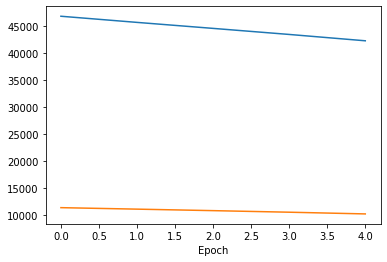

In [ ]:
import matplotlib.pyplot as plt

y_train = []
for tensor in all_train_losses:
  y_train.append(tensor.item())

y_test = []
for tensor in all_test_losses:
  y_test.append(tensor.item())

x = range(len(y_train))

plt.xlabel("Epoch")
plt.ylabel("")
plt.plot(x, y_train)
plt.plot(x, y_test)
plt.show()